In [5]:
# Import Libraries
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display
from pathlib import Path  

import snscrape.modules.twitter as sntwitter
import datetime 
# import matplotlib.cm as cm
from pylab import text
import collections


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amer_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Master functions
*Functions that I would use everywhere*

### Wordcloud generator
*All this function does is initialize the wordcloud data in one simple place so it's cleaner later

In [2]:

noOfTweet = 50000
keyword = input("Enter the searchterm: ")
currentYear = datetime.datetime.now().year
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
file_dir = Path.cwd()

json_folder = 'Colleges'
file_path = os.path.join(file_dir, json_folder, 'College Data',keyword.capitalize())
if not os.path.exists(file_path):
    os.makedirs(file_path)
# extract the county collumn from the countyDF and convert its values to a list
usefulTweets = 0
users = []
county_needed = []
tweets_list2 = []
total_data = []
collegeDF = pd.DataFrame(columns=['pos','posCount','neg','negCount','neu','neuCount','count','comp'])





In [3]:
def topwords(textDF,punctuation_included_list,top,tweetamount):
    # textDF is the dataframe containing the tweets

    # top is the number of top words to be displayed TODO MAKE THIS A FUNCTION OF THE MAX WORDS, NOT A CONSTANT



    # tweetamount is the number of tweets to be displayed
    stopwords = set(STOPWORDS)
    extrawords = keyword.split()
    extrawords+=['https','http','www','will',keyword,'college','student','students','know','colleges','university']
    stopwords.update(extrawords)
    newTweets = textDF.copy()
    newTweets = newTweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # test['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    words = newTweets.tolist()

    # wordi=textDF['text'].tolist()
    # wordi=[word.split for word in wordi]
    # split words into a list of its words

    words = [word.split() for word in words]
    count =collections.Counter([x for sublist in words for x in sublist])
    
    newcount = count.copy()
    for key in count.keys():
        if len(key) < 4:
            del newcount[key]
    # count is a dictionary
    max ={}
    # define some arbitraty top number for tweets
    for k,v in newcount.most_common(top):
        max[k] = v

    # for each word in the max dictionary, find n number of tweets in textDF that contain that word
    # and add it to a list
    
    df = pd.DataFrame(max, columns = ['keyword','count','tweets'])
    for word in max.keys():
        top_tweets=punctuation_included_list.loc[punctuation_included_list['text'].str.contains(word)][:tweetamount]['text'].tolist()
        if(top_tweets==[]):
            top_tweets=textDF.loc[textDF['text'].str.contains(word)][:tweetamount]['text'].tolist()

        # print(top_tweets)
        df.loc[len(df)] = [word,max[word],top_tweets]
        # second column of top_tweets
        

    # df = df.loc[df['count'] >(df['count'].max()*lowerbound)]
    # for k,v in newcount.most_common(top):
    #     max[k] = v
    # concatenate all the tweets in the list

    return(df)


In [4]:
extrawords = keyword.split()+list(map(lambda x: x.lower(), keyword.split()))+[keyword.lower()]
extrawords+=['https','http','www','will',keyword,'college','student','students','know','colleges','university']
print(extrawords)

['Emory', 'emory', 'emory', 'https', 'http', 'www', 'will', 'Emory', 'college', 'student', 'students', 'know', 'colleges', 'university']


In [5]:
def pullTweets(keyword,noOfTweet,time):
    tweets_list2 = []
    for j,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword + ' ' + time).get_items()):
        tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
        if j == noOfTweet-1:
            return tweets_list2
    return tweets_list2
def percentage(part,whole):
    return 100 * float(part)/float(whole)
def average(arr):
    if len(arr)>0:
        return round((sum(arr) / len(arr)),4)

## Am I going crazy?

In [6]:
# First thing is to iterate through each month after working
searchword = ''
wordDB = pd.DataFrame()
for month in range(1,14):
    currentMonth = datetime.datetime.now().month
    # start at the last completed month and count forward
    monthy = currentMonth-1
    monthy +=month-1
    if(monthy>12):
        monthy = monthy-12
        year = currentYear
    else:
        year = currentYear-1
    # I could probably make a way to flip between 30 and 31 days in a month but I'm lazy and it's one day
    if (monthy ==2):
        day = 28
    else:
        day = 30
    timeSearchParams = f'until:{year}-{monthy}-{day} since:{year}-{monthy}-01'
    print(timeSearchParams)
    tweets_list2 = pullTweets(keyword,noOfTweet,timeSearchParams)
    # One of the issues found was that due to the repeated run command, this would have trouble breaking on its own

    # Thus I wrote it into a function that would break and return the needed data at the limi
    tweets_df = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
    posList = []
    negList = []
    neuList = []
    compList = []
    tweetlist = []
    posCount,negCount,neuCount = 0,0,0
    for index,tweet in tweets_df.iterrows():
        # location = tweet.user.location
        username = tweet['Username']
        tweetText = tweet['Text']
        analysis = TextBlob(tweetText)
        score = SentimentIntensityAnalyzer().polarity_scores(tweetText)
        # SCORE RETURNING IS FINE
        neg = score['neg']

        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        # comp variable still works
        # ISSUE IS WITH UP HERE!!!
        # sortTweetCondition = (username not in users) and (tweetText not in tweet_list)
        sortTweetCondition = True
        if (sortTweetCondition == True):
            # append each score to their respective list
            posList.append(pos)
            negList.append(neg)
            neuList.append(neu)
            compList.append(comp)
            usefulTweets+=1
            polarity += analysis.sentiment.polarity
            if neg > pos:
                negative_list.append(tweetText)
                negative += 1
                negCount+=1
            elif pos > neg:
                positive_list.append(tweetText)
                positive += 1
                posCount+=1
            elif pos == neg:
                neutral_list.append(tweetText)
                neutral += 1
                neuCount+=1
            users.append(username)
            tweetlist.append(tweetText)
            if(searchword !='' and searchword in tweetText):print(username + " " + tweetText)
            
        
        # save the cityDict to a json file at directory file_path
        
    pos = average(posList)
    neg = average(negList)
    neu = average(neuList)    
    comp = average(compList)    
    count = posCount+negCount+neuCount
    tweetlist=pd.DataFrame(tweetlist)
    tw_list = pd.DataFrame(tweetlist)
    tw_list["text"] = tw_list[0]

    #Removing RT, Punctuation etc
    remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
    rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
    punctuation_included_list = tw_list.copy()
    tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
    tw_list["text"] = tw_list.text.str.lower()
    tw_list.head(tweetlist.shape[0])
    topWords = topwords(tw_list,punctuation_included_list,50,50)

    topWords.insert(0,'Month',f'{monthy}\'{str(year)[2:]}',0)
    if(len(posList) > 0):
        collegeDF.loc[f'{monthy}\'{str(year)[2:]}'] = [pos,posCount,neg,negCount,neu,neuCount,count,comp]
        wordDB = pd.concat([wordDB,topWords],axis=0)
    else:
        print(f'{month} returned no tweets')
# delete the second index of cityDict
# make a new dictionary identical to countyDict but without the second index
wordDB.set_index(['Month','keyword'],inplace=True)
collegeDF.to_csv(os.path.join(file_path,f'{keyword}_sentiment_analysis.csv'))
wordDB.to_csv(os.path.join(file_path,f'{keyword} tweet info.csv'))

collegeDF

until:2021-3-30 since:2021-3-01
until:2021-4-30 since:2021-4-01
until:2021-5-30 since:2021-5-01
until:2021-6-30 since:2021-6-01
until:2021-7-30 since:2021-7-01
until:2021-8-30 since:2021-8-01
until:2021-9-30 since:2021-9-01
until:2021-10-30 since:2021-10-01
until:2021-11-30 since:2021-11-01
until:2021-12-30 since:2021-12-01
until:2022-1-30 since:2022-1-01
until:2022-2-28 since:2022-2-01
until:2022-3-30 since:2022-3-01


,pos,posCount,neg,negCount,neu,neuCount,count,comp
3'21,0.1114,4240.0,0.0506,1871.0,0.8371,3981.0,10092.0,0.1523
4'21,0.1024,4123.0,0.0543,2180.0,0.8419,4111.0,10414.0,0.1239
5'21,0.1020,4119.0,0.0444,1733.0,0.8533,4329.0,10181.0,0.1468
6'21,0.0970,3337.0,0.0535,1880.0,0.8492,3941.0,9158.0,0.1096
7'21,0.0738,3618.0,0.0728,4548.0,0.8530,3644.0,11810.0,0.0311
8'21,0.0682,4254.0,0.0762,6121.0,0.8551,4922.0,15297.0,0.0160
9'21,0.0943,11874.0,0.0792,10944.0,0.8264,11588.0,34406.0,0.0560
10'21,0.0794,8123.0,0.0715,8660.0,0.8490,10578.0,27361.0,0.0368
11'21,0.0746,6207.0,0.0743,7664.0,0.8510,8701.0,22572.0,0.0215
12'21,0.0715,5011.0,0.0778,7041.0,0.8506,7071.0,19123.0,0.0063


In [7]:
sentiment=collegeDF['comp'].to_list()
monthNames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plotTitle=''
# capitalizing all the words
for i,word in enumerate(keyword.split()):
    if(i!=len(keyword.split())):
        plotTitle += word.capitalize() + ' '
keyword = plotTitle

wordDB.reset_index(inplace=True)
blah = wordDB['count'].tolist()
highestPopPoint = wordDB.loc[wordDB['count']==max(blah)]['Month'].to_list()[0]
# wordDB.loc[wordDB['count']==max(blah)]['Month']

wordDB.set_index(['Month','keyword'],inplace=True)



# start at the last completed month and count forward

months = []
for i in range(13):
    monthy = currentMonth-1
    monthy +=i
    if(monthy>12):
        monthy = monthy-12
        year = currentYear
    else:
        year = currentYear-1
    year = str(year)[2:]
    months.append(f'{monthNames[monthy-1]}\'{year}')


In [8]:
months = []
for i in range(13):
    monthy = currentMonth-1
    monthy +=i
    if(monthy>12):
        monthy = monthy-12
        year = currentYear
    else:
        year = currentYear-1
    year = str(year)[2:]
    months.append(f'{monthNames[monthy-1]}\'{year}')

def convert_to_name(i):
    monthd = currentMonth-1
    monthd +=i
    if(monthd>12):
        monthd = monthd-12
        year = currentYear
    else:
        year = currentYear-1
    year = str(year)[2:]
    return f'{monthd-1}\'{year}'
print(highestPopPoint)

9'21


               count                                             tweets
keyword                                                                
emory          25219  [@juicedudez new tonetag /i love emory everyon...
jones           6238  [@finebaum Chris here from Gainesville, but li...
time            5067  [Almost game time! The stream to watch #ACFTMe...
0mph            4781  [Time 07:50PM Temperature 77.7°F Winds 0.0mph ...
pressure        4286  [🚨 WEEK 5 PREVIEW 🚨  \n\n▪️ #7 Cincinnati (-2....
temperature     4177  [Emory News: Emory physicists show how low tem...
winds           4174  [time 07 50pm temperature 77 7 f winds 0 0mph ...
gust            4174  [@Joe_twheets @emporer_naked @FactFinderMN @St...
precipitation   4173  [time 07 50pm temperature 77 7 f winds 0 0mph ...
00in            2988  [Time 07:50PM Temperature 77.7°F Winds 0.0mph ...
game            2118  [Almost game time! The stream to watch #ACFTMe...
richardson      1593  [Anthony richardson is rhe better quarterb

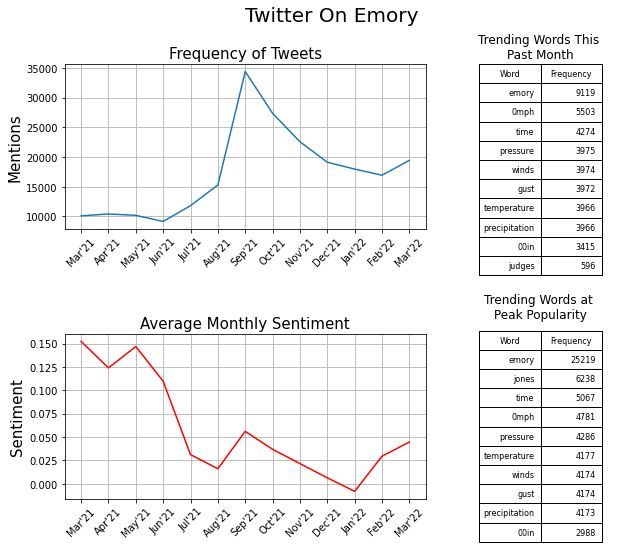

In [9]:


fig = plt.figure()

ax = plt.subplot2grid((5, 3), (0, 0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid((5, 3), (3, 0), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((6, 3), (1, 2), colspan=1)
ax4 = plt.subplot2grid((10, 3), (8, 2), colspan=1)



fig.set_size_inches(10, 8)
# Making all of the month labels line up to the data


ax.xaxis.set_major_locator(plt.MaxNLocator(14))
ax2.xaxis.set_major_locator(plt.MaxNLocator(14))
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
# ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
# print(sentiment)
popularity = collegeDF['count'].to_list()

ax.plot(months,popularity)
ax2.plot(months,sentiment,color='red')
# wordDB.loc[convert_to_name(13).items]
banana=wordDB.loc[convert_to_name(13)]
apple=wordDB.loc[highestPopPoint]
print(apple)
a=zip(banana.index[:10],banana['count'][:10])
b=zip(apple.index[:10],apple['count'][:10])
tableDF = pd.DataFrame(a,columns=['Word','Frequency'])
table2DF = pd.DataFrame(b,columns=['Word','Frequency'])
table = ax3.table(cellText=tableDF.values, colLabels=tableDF.columns, loc='center')
table2 = ax4.table(cellText=table2DF.values, colLabels=table2DF.columns, loc='center')

ax.set_title('Frequency of Tweets',fontsize = 15)
ax3.set_title('Trending Words This \nPast Month',pad= 80)
ax4.set_title('Trending Words at \nPeak Popularity',pad= 100)
ax2.set_title('Average Monthly Sentiment',fontsize = 15)

ax.set_ylabel('Mentions',fontsize = 15)
ax2.set_ylabel('Sentiment',fontsize = 15)
ax.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)

ax2.grid(True)
ax.grid(True)


fig.suptitle(f'Twitter On {keyword}',fontsize = 20)
# plt.xticks(rotation=45)
ax3.axis('off')
ax3.axis('tight')
#create table

ax4.axis('off')
ax4.axis('tight')
#display table
table.set_fontsize(20)
table.scale(.75,1.6)
table2.set_fontsize(20)
table2.scale(.75,1.6)

file_path = os.path.join(file_dir, json_folder,'Graphics', (f'{keyword}.png'))

plt.savefig(file_path,dpi=300,facecolor='white', transparent=False)

In [13]:
wordDB.loc['1\'22']
wordDB

count                                             tweets
Month keyword                                                            
3'21  emory       7497  ['@emory_he @lauferlaw @soledadobrien Correct!...
      atlanta      408  ['We would like to thank all of the Emory Univ...
      henry        330  ['Many thanks to Emory &amp; Henry College Ath...
      time         324  ['@lmp9901 @shawnbowey @odacathletics I hope t...
      today        312  ['@chuggaaconroy I got mine today too!  Emory ...
...                ...                                                ...
3'22  preserved    295  ['#USA justice?\n\ncourt case against #EmoryUn...
      4mph         293  ['Time 03:50PM Temperature 65.5°F Winds 0.0mph...
      henry        285  ['Very proud of my daughter, officially commit...
      1020         284  ['Time 03:00PM Temperature 75.7°F Winds 0.0mph...
      1017         279  ['Time 07:00PM Temperature 74.7°F Winds 0.0mph...

[650 rows x 2 columns]

## Reading Prev Data

In [7]:

readword = 'emory'
readword = readword.capitalize()
file_dir = Path.cwd()
json_folder = 'Colleges'

file_path = os.path.join(file_dir, json_folder, 'College Data',readword.capitalize())

sentiment = os.path.join(file_path,f'{readword}_sentiment_analysis.csv')
wordDB=os.path.join(file_path,f'{readword} tweet info.csv')
sentiment= pd.read_csv(sentiment)
wordDB = pd.read_csv(wordDB)
wordDB.set_index(['Month','keyword'],inplace=True)
sentiment = sentiment.rename(columns={'Unnamed: 0':'Month'})
sentiment.set_index('Month',inplace=True)

In [11]:
wordDB.loc[('7\'21','jones')]['tweets']
wordDB.loc['7\'21']


,count,tweets
keyword,,
emory,6785,"['@barbosa_emory força amgo', '@emory_harris H..."
0mph,4029,['Time 07:50PM Temperature 95.4°F Winds 0.0mph...
time,3262,"[""@Lexxbug @ShamanWallace @primalpoly @CDCgov ..."
pressure,3048,['@emory_he @labadorer @winnieokelley @Sullivi...
temperature,3040,['Emory &amp; Henry students collect temperatu...
winds,3040,['The winds are howling at Emory University At...
gust,3039,['ICYMI: @AdamMarcusPhD has been named deputy ...
precipitation,3037,['time 07 50pm temperature 95 4 f winds 0 0mph...
00in,2272,['Time 07:50PM Temperature 95.4°F Winds 0.0mph...
